# Ejercicio 5: Flux for logistic regression
Empezmo con la carga de datos y paqueteris necesarias, vamos a separar los datos en 2 archivos, uno de entrenamiento y el otro de prueba

In [123]:
using CSV
using DataFrames
using Flux
using MLDataUtils

# Cargar los datos
data = CSV.read("Churn_Modelling.csv", DataFrame)

# Seleccionar columnas relevantes
selected_columns = [
    :CreditScore, :Age, :Tenure, :Balance,
    :NumOfProducts, :HasCrCard, :IsActiveMember, :EstimatedSalary, :Exited
]
data = data[:, selected_columns]


# Normalización de variables numéricas
function normalize!(df, cols)
    for col in cols
        mean_val = mean(df[!, col])
        std_val = std(df[!, col])
        df[!, col] = (df[!, col] .- mean_val) ./ std_val
    end
    return df
end
numerical_features = [:CreditScore, :Age, :Tenure, :Balance, :NumOfProducts, :EstimatedSalary]
data = normalize!(data, numerical_features)

# Dividir en conjuntos de entrenamiento y prueba
train_data, test_data = splitobs(shuffleobs(data), at = 0.8)

# Guardar los conjuntos de datos preprocesados
CSV.write("train_preprocessed.csv", train_data)
CSV.write("test_preprocessed.csv", test_data)

"test_preprocessed.csv"

Realizamos el modelo denso de regresion logistica

In [124]:
using Flux
using CSV
using DataFrames
using EvalMetrics

# Cargar los datos
train = CSV.read("train_preprocessed.csv", DataFrame)
test = CSV.read("test_preprocessed.csv", DataFrame)

X_train = Matrix(train[:, 1:end-1])'
y_train = convert(Array{Float32}, train[:, end])'

X_test = Matrix(test[:, 1:end-1])'
y_test = convert(Array{Float32}, test[:, end])'

# Definir el modelo de regresión logística
model = Dense(8, 1) 

# Función de pérdida (log-loss)
loss(model, x, y) = Flux.logitbinarycrossentropy(model(x), y)
#loss(model, x, y) = mean(abs2.(model(x) .- y));

opt = Descent()
data = [(X_train, y_train)]

using Flux: train!

for epoch in 1:100
    train!(loss, model, data, opt)
  end


# Predicciones en el conjunto de prueba
y_pred = model(X_test) .> 0.5  # Clasificación binaria


1×2000 BitMatrix:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0

Se calcula la matriz de confusion

In [125]:
using Statistics

# Convertir predicciones binarias a 0 y 1
y_pred_binary = y_pred .> 0.5

# Crear la matriz de confusión
function confusion_matrix(y_true, y_pred)
    TP = sum((y_true .== 1) .& (y_pred .== 1))  # Verdaderos positivos
    TN = sum((y_true .== 0) .& (y_pred .== 0))  # Verdaderos negativos
    FP = sum((y_true .== 0) .& (y_pred .== 1))  # Falsos positivos
    FN = sum((y_true .== 1) .& (y_pred .== 0))  # Falsos negativos
    return [TP FP; FN TN]  # Matriz de confusión
end

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Mostrar la matriz de confusión
println("Matriz de Confusión:")
println("TP | FP")
println("FN | TN")
println(conf_matrix)

Matriz de Confusión:
TP | FP
FN | TN
[10 27; 380 1583]


Se calcula la curva ROC

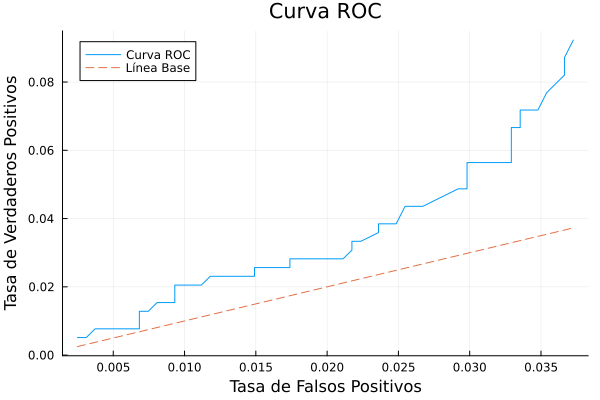

In [126]:
using Plots
# Función para calcular los puntos de la curva ROC
function calculate_roc(y_true, y_scores; num_thresholds=100)
    thresholds = range(0.0, stop=1.0, length=num_thresholds)
    tpr = zeros(num_thresholds)  # True Positive Rate
    fpr = zeros(num_thresholds)  # False Positive Rate

    for (i, threshold) in enumerate(thresholds)
        tp = sum((y_scores .>= threshold) .& (y_true .== true))
        fp = sum((y_scores .>= threshold) .& (y_true .== false))
        fn = sum((y_scores .< threshold) .& (y_true .== true))
        tn = sum((y_scores .< threshold) .& (y_true .== false))

        tpr[i] = tp / (tp + fn)  # True Positive Rate
        fpr[i] = fp / (fp + tn)  # False Positive Rate
    end

    return fpr, tpr
end

# Calcular los puntos de la curva ROC
fpr, tpr = calculate_roc(y_test, model(X_test))

# Graficar la curva ROC
plot(fpr, tpr, label="Curva ROC", xlabel="Tasa de Falsos Positivos", ylabel="Tasa de Verdaderos Positivos", title="Curva ROC")
plot!(x -> x, label="Línea Base", linestyle=:dash)

Por los resultados obtenidos, parece ser que no hay muy buenas predicciones, he intentado con mas epocas de entrenamiento, diferentes funciones de perdida y metodos de optimizacion pero no parece funcionar, la prediccion siempre parece ser de alreedor del 60%